In [31]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [32]:
train_data = np.loadtxt("./../data/galaxies_train.csv", delimiter=",", skiprows=1)
test_data = np.loadtxt("./../data/galaxies_test.csv", delimiter=",", skiprows=1)

In [33]:
X_train = train_data[:,1:]
t_train = train_data[:,0]
X_test = test_data[:,1:]
t_test = test_data[:,0]
print("Number of training instances: %i" % X_train.shape[0])
print("Number of test instances: %i" % X_test.shape[0])
print("Number of attributes: %i" % X_train.shape[1])

Number of training instances: 500
Number of test instances: 500
Number of attributes: 10


In [34]:
class NearestNeighborRegressor:
    
    def __init__(self, n_neighbors=15):
        """
        Initializes the model.
        
        Parameters
        ----------
        n_neighbors : The number of nearest neigbhors (default 1)
        dist_measure : The distance measure used (default "euclidean")
        dist_matrix : The distance matrix if needed (default "None")
        """
        
        self.n_neighbors = n_neighbors
    
    def fit(self, X, t):
        """
        Fits the nearest neighbor regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        t : Array of length n_samples
        """ 
        
        self.X_train = X
        self.t_train = t
    
    def find_nearest_neigbours(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of length n_samples
        """         
        
        nearest_neigbours_x = []
        nearest_neigbours_t = []
        
        for i in X:
            distance_array = []
            for j in self.X_train:
                dist = np.linalg.norm(i - j)
                distance_array.append(dist)

            # Finds the k nearest neighbours
            # Code snippet found at https://stackoverflow.com/a/34226816
            nearest_index = np.argpartition(distance_array, self.n_neighbors)[:self.n_neighbors]
            nearest_neigbours_x = np.append(nearest_neigbours_x, self.X_train[nearest_index])
            nearest_neigbours_t = np.append(nearest_neigbours_t, self.t_train[nearest_index])
            
        nearest_neigbours_x = np.array(nearest_neigbours_x).reshape((-1, X_train.shape[1]))
        nearest_neigbours_t = np.array(nearest_neigbours_t).reshape((-1, 1))

        return nearest_neigbours_x, nearest_neigbours_t

In [35]:
class regularized_least_squares():
    def __init__(self, lamb = 1.0, k = 15):
        self.lamb = lamb
        self.k = k
        self.weights = []
        
    def fit(self, X, t):
        for i in range(0, len(X), self.k):
            X_temp = X[i:i + self.k]
            t_temp = t[i:i + self.k]
            X_temp = np.insert(X_temp, 0, 1, axis = 1)
            XtX = np.matmul(X_temp.T, X_temp)
            N = len(X_temp)
            NLI = N * self.lamb * np.identity(len(XtX))
            parenthesis = np.linalg.inv(XtX + NLI)
            idk = np.matmul(parenthesis, X_temp.T)
            self.weights.append(np.matmul(idk, t_temp))
        
        self.weights = np.array(self.weights).reshape(int(len(X)/self.k), -1)
        
    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            X_temp = np.insert(X[i], 0, 1)
            predictions.append(np.matmul(X_temp, self.weights[i]))

        predictions = np.array(predictions).reshape((len(predictions), -1))
        return predictions
    
    # Calculates the RMSE between the true value, t, and the predicted value, tp.
    # This function has been taken from my answer to assignment 1.
    # The assignment was fully made by me and not made in any collaborations.
    def RMSE(self, t, tp):
        N = len(t)
        s = 0
        for i in range(N):
            s += np.linalg.norm((t[i] - tp[i]))**2
        s /= N
        s = s**(0.5)
        return s

In [36]:
kNN_model = NearestNeighborRegressor()
kNN_model.fit(X_train, t_train)
nearest_neigbours_x, nearest_neigbours_t = kNN_model.find_nearest_neigbours(X_test)

In [37]:
least_square_model = regularized_least_squares()
least_square_model.fit(nearest_neigbours_x, nearest_neigbours_t)
tp = least_square_model.predict(X_test)

# RMSE
print(least_square_model.RMSE(t_test, tp))

0.8925765347348245


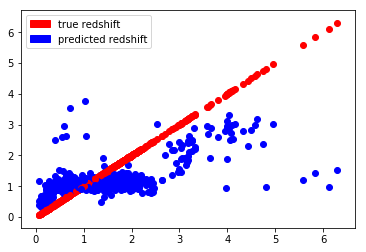

In [38]:
# Scatter
for i in range(len(tp)):
    plt.scatter(t_test[i], t_test[i], c = "red")
    plt.scatter(t_test[i], tp[i], c = "blue")
    
red_patch = Patch(color = "red", label = "true redshift")
blue_patch = Patch(color = "blue", label = "predicted redshift")
plt.legend(handles = [red_patch, blue_patch], loc = "best")
plt.show()